In [30]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import cv2   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization                               

In [2]:
path_to_data = "../data/minet"

In [3]:
image_names = []
train_labels = []
train_images = []

size = (150, 150)

for folder in os.listdir(path_to_data):
    for file in os.listdir(os.path.join(path_to_data, folder)):
        if file.endswith("jpg"):
            image_names.append(os.path.join(path_to_data, folder, file))
            train_labels.append(folder)
            img = cv2.imread(os.path.join(path_to_data, folder, file))
            im = cv2.resize(img, size)
            train_images.append(im)
        else:
            continue

In [4]:
encoder = LabelEncoder()
y = encoder.fit_transform(train_labels)
n_classes = len(np.unique(y))

In [5]:
y = to_categorical(y, n_classes)

In [6]:
X = np.array(train_images)
X = X / 255

In [7]:
y.shape

(930, 7)

In [8]:
X.shape

(930, 150, 150, 3)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [10]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(y.shape[1], activation = "softmax"))

In [11]:
batch_size = 128
epochs = 50

In [12]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False
) # randomly flip images

datagen.fit(X_train)

In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs = epochs, 
    validation_data = (X_test, y_test),
    verbose = 1, 
    steps_per_epoch=X_train.shape[0] // batch_size
)

Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 2.0402 - accuracy: 0.2409 - val_loss: 1.8369 - val_accuracy: 0.2473
Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 1.7992 - accuracy: 0.2734 - val_loss: 1.6168 - val_accuracy: 0.4014
Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 1.6533 - accuracy: 0.3346 - val_loss: 1.6895 - val_accuracy: 0.2509
Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 1.6023 - accuracy: 0.3365 - val_loss: 1.4861 - val_accuracy: 0.4014
Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 1.4577 - accuracy: 0.4704 - val_loss: 1.4197 - val_accuracy: 0.4552
Epoch 6/50
5/5 [==============================] - 5s 1s/step - loss: 1.3835 - accuracy: 0.4685 - val_loss: 1.4089 - val_accuracy: 0.4552
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 1.2750 - accuracy: 0.4922 - val_loss: 1.3143 - val_accuracy: 0.4624
Epoch 8/50
5/5 [=========================

In [15]:
predictions = model.predict(X_test)

9/9 [==============================] - 1s 53ms/step


In [24]:
y_pred = encoder.inverse_transform(np.argmax(predictions, axis=1))

In [25]:
y_true = encoder.inverse_transform(np.argmax(y_test, axis=1))

In [26]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

     biotite       0.54      0.72      0.62        18
     bornite       0.75      0.86      0.80        56
 chrysocolla       0.76      0.76      0.76        51
   malachite       0.90      0.78      0.84        69
   muscovite       0.57      0.42      0.48        19
      pyrite       0.80      0.71      0.75        28
      quartz       0.83      0.89      0.86        38

    accuracy                           0.77       279
   macro avg       0.74      0.74      0.73       279
weighted avg       0.78      0.77      0.77       279



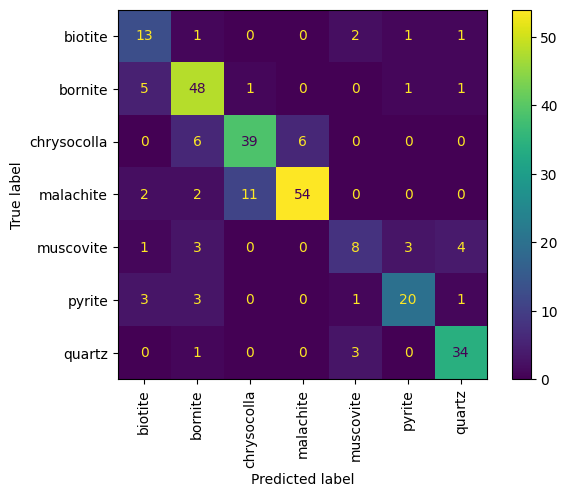

In [33]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, xticks_rotation="vertical");